In [5]:
# Install necessary libraries
%pip install imblearn google-cloud-bigquery

In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.cloud import bigquery
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Initialize BigQuery client
client = bigquery.Client()

# Set Seaborn style for better plots
sns.set(style="whitegrid")


In [7]:
# Load stored feature-engineered data from BigQuery
query = "SELECT * FROM `just-data-sandbox-oos.ENEL_645.FE9_merged_features`"
df = client.query(query).to_dataframe()

# Display settings for better readability
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Prevent text truncation

# Ensure 'createdTime' is in datetime format before sorting
df['createdTime'] = pd.to_datetime(df['createdTime'], errors='coerce')

# Sort dataset chronologically
df = df.sort_values(by='createdTime', ascending=True)

# Display first few rows of the dataset
df.head()

,uid,createdTime,resId,itemId,qty,scenario,hour,dayPhase,AM_PM,dd,weekday,weekday_weekend,month,quarter,resNumOrders1h,resNumOrders3h,resNumOrders6h,resNumOrders1d,resNumOrders3d,resNumOrders1w,resQty1h,resQty3h,resQty6h,resQty1d,resQty3d,resQty1w,resNumOOS1h,resNumOOS3h,resNumOOS6h,resNumOOS1d,resNumOOS3d,resNumOOS1w,resTimeSincePrevRestock,irNumOrders1h,irNumOrders3h,irNumOrders6h,irNumOrders1d,irNumOrders3d,irNumOrders1w,irQty1h,irQty3h,irQty6h,irQty24h,irQty3d,irQty1w,irTimeSincePrevOrder,irPrevScenario,irTimeSincePrevOOS,irNumOOS1h,irNumOOS3h,irNumOOS6h,irNumOOS1d,irNumOOS3d,irNumOOS1w,irOOSRate1h,irOOSRate3h,irOOSRate6h,irOOSRate1d,irOOSRate3d,irOOSRate1w,irTimeSincePrevRestock,irPrevRestockTime,irTimeSinceLastDelivered
107280,a2556aa8-d4dc-4f25-b9c4-395980444abf,2025-01-01 07:01:28+00:00,11f1f94555e155adba5f3f87e6e4f020d7647a5a6447bd891de53c20318288f9,6a5d7b6d98cc9a0c7df6dcd8edcb92492f44cb8d29afad7ff9121bdae9b6df3d,4,DELIVERED,7,Morning,AM,01,Wednesday,Weekday,January,1,0,0,0,0,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0,0,0,0,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,None,<NA>,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>
214952,4c61329b-3fd8-4a8f-b04e-f0fe4afbf7f9,2025-01-01 07:04:54+00:00,2792271a088e78819e9b03a12250755cdfec7401bf8ceb9f6b3d668d3665e902,6df4699463399216b6147fda0472751dd3f7de8957d8fd34303bcb9889d9d245,3,DELIVERED,7,Morning,AM,01,Wednesday,Weekday,January,1,0,0,0,0,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0,0,0,0,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,None,<NA>,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>
0,d943c0ce-2be3-437b-9df8-eceede24fb7a,2025-01-01 07:08:33+00:00,007c0cb81363275a5b01a2387a62945960f25f263b9459d06887e30945c77869,b95ce666368b54f741ff3eedb093be070ebeb762e426f42c1ed3a039a7609409,5,DELIVERED,7,Morning,AM,01,Wednesday,Weekday,January,1,0,0,0,0,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0,0,0,0,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,None,<NA>,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>
85975,3e72cde7-bafb-4341-bb09-811fa1a46095,2025-01-01 07:15:43+00:00,0fdea8d9e04c62470212893153397071ef50331fd4f42963d4a03b0b595f8fd2,bf382318dcbb848b83aaa0d5fcb1c490f6a1873ca3107eb95da84bddc49fe3a2,5,DELIVERED,7,Morning,AM,01,Wednesday,Weekday,January,1,0,0,0,0,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0,0,0,0,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,None,<NA>,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>
107281,31ba0aa0-bf21-4995-9fdd-ca129e559f61,2025-01-01 07:16:52+00:00,11f1f94555e155adba5f3f87e6e4f020d7647a5a6447bd891de53c20318288f9,29082b7a722290b205c59b61eda13463d64424e1ab8bd37c121601d8365c6e13,4,DELIVERED,7,Morning,AM,01,Wednesday,Weekday,January,1,1,1,1,1,1,1,4,4,4,4,4,4,0,0,0,0,0,0,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,None,<NA>,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>


In [8]:
# Encode categorical binary columns using mapping
binary_mappings = {
    'AM_PM': {'AM': 0, 'PM': 1},  # Convert AM/PM to 0/1
    'weekday_weekend': {'Weekday': 0, 'Weekend': 1},  # Convert Weekday/Weekend to 0/1
    'scenario': {'DELIVERED': 0, 'OUT_OF_STOCK': 1},  # Convert scenario to 0/1
}

# Apply mappings
df.replace(binary_mappings, inplace=True)

# Rename columns for clarity
df.rename(columns={'AM_PM': 'isPM', 'weekday_weekend': 'isWeekend', 'scenario': 'isOOS'}, inplace=True)

# Display first few rows of the updated binary columns
df[['isPM', 'isWeekend', 'isOOS']].head()


,isPM,isWeekend,isOOS
107280,0,0,0
214952,0,0,0
0,0,0,0
85975,0,0,0
107281,0,0,0


In [9]:
# Drop rows for the first month since some features require prior data
# Our dataset starts from 2025-01-01 07:01:28 UTC.

df['createdTime'] = pd.to_datetime(df['createdTime'], utc=True)  # Ensure datetime format

# Define cutoff timestamps based on feature lookback windows
cutoff_times = {
    "1h": pd.Timestamp("2025-01-01 08:01:28", tz='UTC'),
    "3h": pd.Timestamp("2025-01-01 10:01:28", tz='UTC'),
    "6h": pd.Timestamp("2025-01-01 13:01:28", tz='UTC'),
    "1d": pd.Timestamp("2025-01-02 07:01:28", tz='UTC'),
    "3d": pd.Timestamp("2025-01-04 07:01:28", tz='UTC'),
    "1w": pd.Timestamp("2025-01-08 07:01:28", tz='UTC'),
    "1m": pd.Timestamp("2025-02-01 07:01:28", tz='UTC'),
}

# Iterate through each cutoff time and apply NaN masking
for suffix, cutoff in cutoff_times.items():
    cols_to_update = [col for col in df.columns if col.endswith(suffix)]

    if cols_to_update:  # Only process if matching columns exist
        print(f"Masking {len(cols_to_update)} columns with suffix '{suffix}' before {cutoff}")
        df[cols_to_update] = df[cols_to_update].mask(df['createdTime'] < cutoff, pd.NA)

# Display the first few rows after applying masking
df.head()


Masking 7 columns with suffix '1h' before 2025-01-01 08:01:28+00:00
Masking 7 columns with suffix '3h' before 2025-01-01 10:01:28+00:00
Masking 7 columns with suffix '6h' before 2025-01-01 13:01:28+00:00
Masking 6 columns with suffix '1d' before 2025-01-02 07:01:28+00:00
Masking 7 columns with suffix '3d' before 2025-01-04 07:01:28+00:00
Masking 7 columns with suffix '1w' before 2025-01-08 07:01:28+00:00


,uid,createdTime,resId,itemId,qty,isOOS,hour,dayPhase,isPM,dd,weekday,isWeekend,month,quarter,resNumOrders1h,resNumOrders3h,resNumOrders6h,resNumOrders1d,resNumOrders3d,resNumOrders1w,resQty1h,resQty3h,resQty6h,resQty1d,resQty3d,resQty1w,resNumOOS1h,resNumOOS3h,resNumOOS6h,resNumOOS1d,resNumOOS3d,resNumOOS1w,resTimeSincePrevRestock,irNumOrders1h,irNumOrders3h,irNumOrders6h,irNumOrders1d,irNumOrders3d,irNumOrders1w,irQty1h,irQty3h,irQty6h,irQty24h,irQty3d,irQty1w,irTimeSincePrevOrder,irPrevScenario,irTimeSincePrevOOS,irNumOOS1h,irNumOOS3h,irNumOOS6h,irNumOOS1d,irNumOOS3d,irNumOOS1w,irOOSRate1h,irOOSRate3h,irOOSRate6h,irOOSRate1d,irOOSRate3d,irOOSRate1w,irTimeSincePrevRestock,irPrevRestockTime,irTimeSinceLastDelivered
107280,a2556aa8-d4dc-4f25-b9c4-395980444abf,2025-01-01 07:01:28+00:00,11f1f94555e155adba5f3f87e6e4f020d7647a5a6447bd891de53c20318288f9,6a5d7b6d98cc9a0c7df6dcd8edcb92492f44cb8d29afad7ff9121bdae9b6df3d,4,0,7,Morning,0,01,Wednesday,0,January,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,<NA>,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
214952,4c61329b-3fd8-4a8f-b04e-f0fe4afbf7f9,2025-01-01 07:04:54+00:00,2792271a088e78819e9b03a12250755cdfec7401bf8ceb9f6b3d668d3665e902,6df4699463399216b6147fda0472751dd3f7de8957d8fd34303bcb9889d9d245,3,0,7,Morning,0,01,Wednesday,0,January,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,<NA>,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
0,d943c0ce-2be3-437b-9df8-eceede24fb7a,2025-01-01 07:08:33+00:00,007c0cb81363275a5b01a2387a62945960f25f263b9459d06887e30945c77869,b95ce666368b54f741ff3eedb093be070ebeb762e426f42c1ed3a039a7609409,5,0,7,Morning,0,01,Wednesday,0,January,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,<NA>,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
85975,3e72cde7-bafb-4341-bb09-811fa1a46095,2025-01-01 07:15:43+00:00,0fdea8d9e04c62470212893153397071ef50331fd4f42963d4a03b0b595f8fd2,bf382318dcbb848b83aaa0d5fcb1c490f6a1873ca3107eb95da84bddc49fe3a2,5,0,7,Morning,0,01,Wednesday,0,January,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,<NA>,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
107281,31ba0aa0-bf21-4995-9fdd-ca129e559f61,2025-01-01 07:16:52+00:00,11f1f94555e155adba5f3f87e6e4f020d7647a5a6447bd891de53c20318288f9,29082b7a722290b205c59b61eda13463d64424e1ab8bd37c121601d8365c6e13,4,0,7,Morning,0,01,Wednesday,0,January,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,<NA>,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>


In [10]:
# Fill all NaN values with 0
df.fillna(0, inplace=True)

# Check if any columns still contain NaN values
missing_counts = df.isnull().sum()

# Print only columns with missing values (if any)
if missing_counts.any():
    print("Warning: Some columns still contain NaN values!")
    print(missing_counts[missing_counts > 0])
else:
    print("✅ No missing values found. Data is clean!")


✅ No missing values found. Data is clean!


In [11]:
# 📊 Data Analysis

# Display dataset information
print(f"✅ Dataset contains {df.shape[0]:,} rows and {df.shape[1]:,} features.")

# Check for missing values
missing_values = df.isnull().sum()
if missing_values.any():
    print("\n⚠️ Warning: Some features contain missing values!")
    print(missing_values[missing_values > 0])
else:
    print("\n✅ No missing values found in the dataset.")

# Check for class imbalance in the target variable
print("\n📊 Class Distribution for 'isOOS':")
print(df['isOOS'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))




✅ Dataset contains 236,570 rows and 63 features.

✅ No missing values found in the dataset.

📊 Class Distribution for 'isOOS':
isOOS
0    97.62%
1     2.38%
Name: proportion, dtype: object


In [12]:
# 📌 Define feature columns and target variable

all_features = [
    "qty", "hour", "isPM", "dd", "isWeekend", "quarter",
    "resNumOrders1h", "resNumOrders3h","resNumOrders1d", "resNumOrders3d", "resNumOrders1w",
    "resQty1h", "resQty3h" ,"resQty6h", "resQty1d", "resQty3d", "resQty1w",
    "resNumOOS1h", "resNumOOS3h", "resNumOOS6h" ,"resNumOOS1d", "resNumOOS3d", "resNumOOS1w",
    "resTimeSincePrevRestock",
    "irNumOrders1h", "irNumOrders3h", "irNumOrders6h" ,"irNumOrders1d", "irNumOrders3d", "irNumOrders1w",
    "irQty1h", "irQty3h", "irQty24h", "irQty3d", "irQty1w",
    "irTimeSincePrevOrder", "irTimeSincePrevOOS",
    "irNumOOS1h","irNumOOS3h", "irNumOOS6h", "irNumOOS1d", "irNumOOS3d", "irNumOOS1w",
    "irTimeSincePrevRestock", "irPrevRestockTime",
    "irTimeSinceLastDelivered"
]

# 📌 Sort dataset by time (chronological order is important for time series)
df = df.sort_values('createdTime')

# 📌 Select required columns, drop any NA values
data = df[all_features + ['isOOS', 'createdTime']].dropna()

In [13]:
# 📌 Define train-test split (80-20 split based on time)
split_index = int(0.8 * len(data))
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# 📌 Extract features (X) and target variable (y)
X_train, y_train = train_data[all_features], train_data['isOOS']
X_test, y_test = test_data[all_features], test_data['isOOS']

# 📌 Ensure correct data types
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

In [14]:
# 🔹 Define Pipeline: SMOTE for handling imbalance + Gradient Boosting Classifier
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.2, random_state=42)),  # Handle imbalanced dataset
    ('classifier', GradientBoostingClassifier(random_state=42))  # Model
])

# 🔹 Define hyperparameter grid for tuning
param_grid = {
    'classifier__n_estimators': [50,100],
    'classifier__learning_rate': [0.1,1],
    'classifier__max_depth': [3,5]
}


⏳ Training model with GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

✅ Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 50}

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46295
           1       0.95      0.84      0.90      1019

    accuracy                           1.00     47314
   macro avg       0.98      0.92      0.95     47314
weighted avg       1.00      1.00      1.00     47314



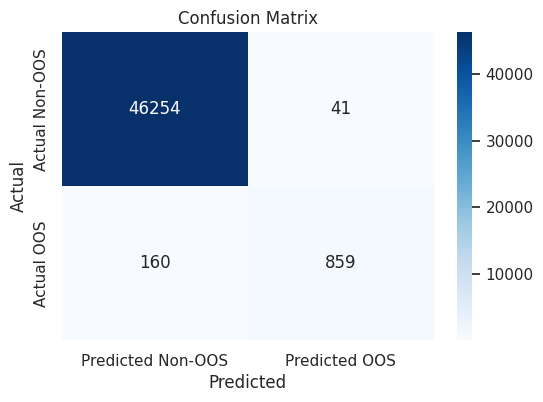

In [15]:
# 🔹 TimeSeriesSplit ensures time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# 🔹 Grid Search with Cross-Validation
grid_search = GridSearchCV(
    pipeline, param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
)

# 🔹 Fit the model
print("\n⏳ Training model with GridSearchCV...")
grid_search.fit(X_train, y_train)

# 📌 Display the best parameters found
print("\n✅ Best Hyperparameters:", grid_search.best_params_)

# 📌 Get the best model and make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 📌 Model Evaluation
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# 📌 Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Non-OOS', 'Predicted OOS'],
            yticklabels=['Actual Non-OOS', 'Actual OOS'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()

In [16]:
#check predicted probability array (1st colum: in-stock probability   2nd column: OOS probability)
print(best_model.predict_proba(X_test))

[[0.9430715  0.0569285 ]
 [0.99813452 0.00186548]
 [0.99813452 0.00186548]
 ...
 [0.99813452 0.00186548]
 [0.99813452 0.00186548]
 [0.99813452 0.00186548]]


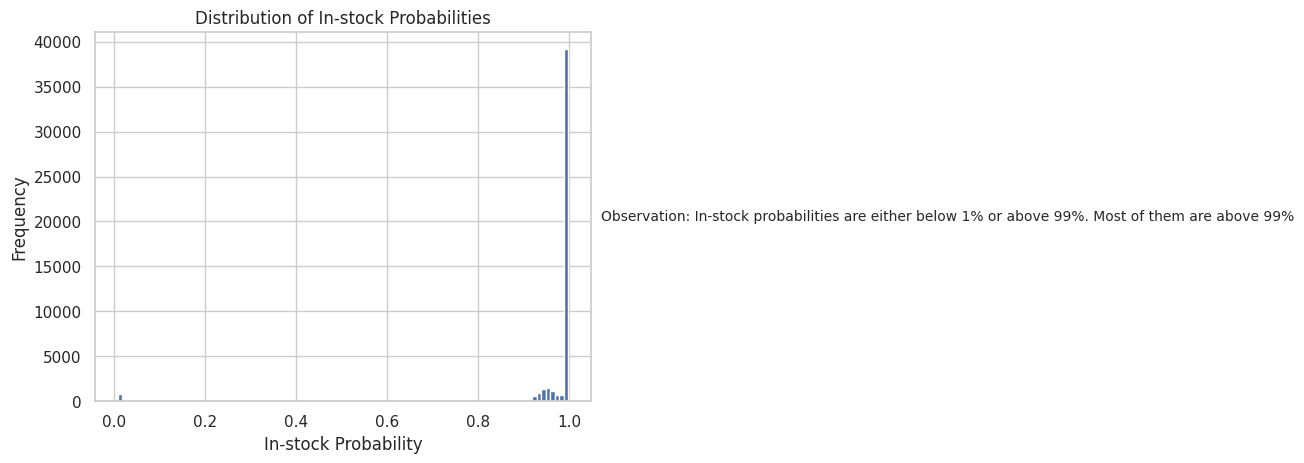

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Get in-stock probabilities from the best model
data = best_model.predict_proba(X_test)[:, 0]

# Plot the histogram
plt.hist(data, bins=100)

# Set labels and title
plt.xlabel('In-stock Probability')
plt.ylabel('Frequency')
plt.title('Distribution of In-stock Probabilities')

# Add a side note with the observation
plt.text(1.02, 0.5, "Observation: In-stock probabilities are either below 1% or above 99%. Most of them are above 99%",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')

# Show the plot
plt.show()


In [ ]:
# Get feature importances from the best model
feature_importances = best_model.named_steps['classifier'].feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': all_features, 'Importance': feature_importances})

# Sort by importance values in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top 20 most important features
pd.options.display.max_rows = 4000
pd.set_option('display.max_colwidth', None)
print(importance_df[:20])


                     Feature  Importance
33        irTimeSincePrevOOS    0.985684
32      irTimeSincePrevOrder    0.004843
39  irTimeSinceLastDelivered    0.002993
21   resTimeSincePrevRestock    0.001263
14                  resQty3d    0.000993
37    irTimeSincePrevRestock    0.000928
9             resNumOrders3d    0.000440
8             resNumOrders1d    0.000438
20               resNumOOS1w    0.000348
13                  resQty1d    0.000341
25             irNumOrders3d    0.000217
31                   irQty1w    0.000164
7             resNumOrders3h    0.000158
38         irPrevRestockTime    0.000130
4                  isWeekend    0.000127
29                  irQty24h    0.000126
3                         dd    0.000101
36                irNumOOS1w    0.000080
35                irNumOOS3d    0.000077
10            resNumOrders1w    0.000071


In [19]:
# Define top 10 and top 5 features based on feature importances
top_10_features = importance_df['Feature'].head(10).tolist()  # Top 10 most important features
top_5_features = importance_df['Feature'].head(5).tolist()    # Top 5 most important features



🔹 Training with All Features (46 features)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46295
           1       0.98      0.84      0.91      1019

    accuracy                           1.00     47314
   macro avg       0.99      0.92      0.95     47314
weighted avg       1.00      1.00      1.00     47314



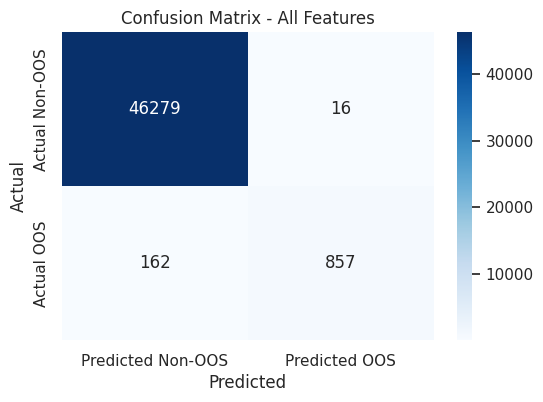


🔹 Training with Top 10 Features (10 features)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46295
           1       1.00      0.84      0.91      1019

    accuracy                           1.00     47314
   macro avg       1.00      0.92      0.96     47314
weighted avg       1.00      1.00      1.00     47314



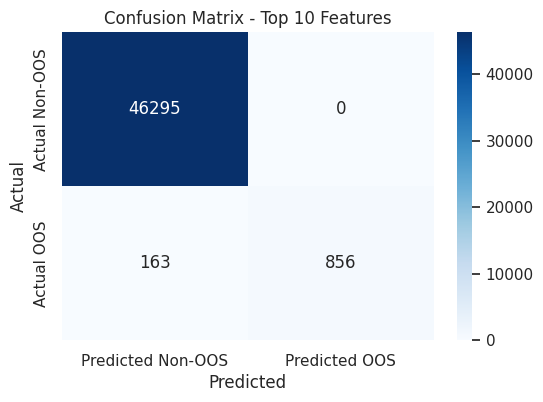


🔹 Training with Top 5 Features (5 features)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46295
           1       1.00      0.84      0.91      1019

    accuracy                           1.00     47314
   macro avg       1.00      0.92      0.96     47314
weighted avg       1.00      1.00      1.00     47314



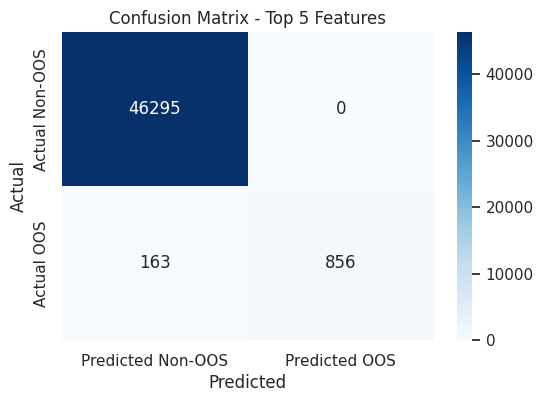

In [20]:
# Function to train & evaluate the model
def train_and_evaluate(features, feature_name):
    print(f"\n🔹 Training with {feature_name} ({len(features)} features)")

    # Prepare Data
    X_train = train_data[features]
    X_test = test_data[features]

    # Train Model
    model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Predicted Non-OOS', 'Predicted OOS'],
                yticklabels=['Actual Non-OOS', 'Actual OOS'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f"Confusion Matrix - {feature_name}")
    plt.show()

# Train with different feature sets
train_and_evaluate(all_features, "All Features")
train_and_evaluate(top_10_features, "Top 10 Features")
train_and_evaluate(top_5_features, "Top 5 Features")
